In [1]:
import pyzed.sl as sl
import math
import numpy as np
import sys
import math
import cv2
import time
PYDEVD_DISABLE_FILE_VALIDATION=1

### Setup

In [2]:
#Define camera
zed = sl.Camera()

#Define params
init_params = sl.InitParameters()
runtime_parameters = sl.RuntimeParameters()

#set init params
init_params.depth_mode = sl.DEPTH_MODE.ULTRA 
init_params.coordinate_units = sl.UNIT.CENTIMETER 
init_params.depth_minimum_distance = 1.5 # Set the minimum depth perception distance to 15cm
init_params.depth_maximum_distance = 1000000000
#Set camera params
#zed.set_camera_settings(sl.VIDEO_SETTINGS.WHITEBALANCE_AUTO, 2)
#zed.set_camera_settings(sl.VIDEO_SETTINGS.DENOISING, 50)


init_params.depth_stabilization = False

#runtime_parameters.sensing_mode = sl.SENSING_MODE.FILL


In [3]:
print(zed.get_init_parameters())
print("******")
print(zed.get_runtime_parameters())

******


In [4]:

err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    print('Fail')
    exit(-1)

### Image Extraction

We now extract and plot depth maps

In [5]:
import matplotlib.pyplot as plt

In [6]:
MAX_RANGE = 1000

In [7]:
def repInf(data):
    data = data.copy()
    data[data == np.inf] = MAX_RANGE
    return data

In [8]:
#ignore nan, not able to get a good read on those pixels
imgs = [] #accumulator
if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    print('success')
    for i in range(1):
        depth = sl.Mat()
        image = sl.Mat()
        zed.retrieve_image(image, sl.VIEW.LEFT)
        zed.retrieve_measure(depth, sl.MEASURE.DEPTH)
        imgs.append(depth.get_data(deep_copy=True))
        print(f'image {i+1}')
        print(imgs)
else:
    print('fail')




success
image 1
[array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ..., 31.150852, 31.201147,
        31.194187],
       [      nan,       nan,       nan, ..., 31.153107, 31.202085,
        31.222258],
       [      nan,       nan,       nan, ..., 31.153107, 31.222258,
        31.222258]], dtype=float32)]


#### Nota Bene
Processing multiple images MAY trigger a kernel crash because jupyter regards it as a frozen module.

Todo fix

1


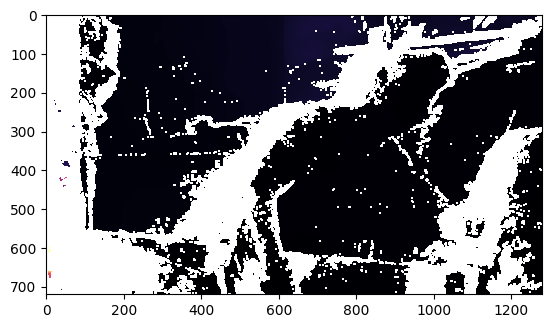

In [9]:

data_dmaps = [repInf(dmap) for dmap in imgs] #inf as -1
print(len(data_dmaps))

#plotting
f = plt.figure()
count = len(data_dmaps)
for i in range(count):
    f.add_subplot(1, count, i+1)
    plt.imshow(data_dmaps[i], cmap='magma')
plt.show()

success
image 1
[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [      nan       nan       nan ... 31.465464 31.474348 31.439627]
 [      nan       nan       nan ... 31.46416  31.471388 31.471388]
 [      nan       nan       nan ... 31.436115 31.471388 31.471388]]


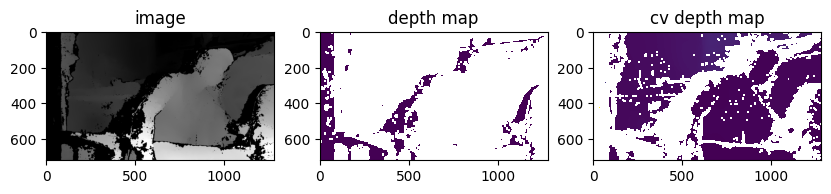

In [10]:
#ignore nan, not able to get a good read on those pixels
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(10, 4)

imgs = [] #accumulator
if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    print('success')
    depth_cv = sl.Mat(1280, 720, sl.MAT_TYPE.U8_C4) # init .mat for int depth for opencv
    depth = sl.Mat() #sl.Mat(1280, 720, sl.MAT_TYPE.F32_C1)   # init .mat for float depth for calc
    image = sl.Mat()                                # init .mat for BGR image
    zed.retrieve_measure(depth, sl.MEASURE.DEPTH)   # fill .mat for int depth for opencv
    zed.retrieve_measure(depth_cv, sl.MEASURE.DEPTH)# fill .mat for float depth for calc
    zed.retrieve_image(image, sl.VIEW.DEPTH )       # fill .mat for BGR image
    depth_cv_nparr = depth_cv.get_data()            # get numpy array for opencv depth mat
    depth_nparr = depth.get_data()                  # get numpy array for calc depth mat
    rgb_nparr = image.get_data()                    # get numpy array for rgb img
    # print(depth_cv_nparr)
    axs[0].imshow(rgb_nparr)             # show cv2 numpy array
    axs[0].set_title("image")
    axs[1].imshow(np.where(np.isnan(depth_nparr), 0, depth_nparr / np.max(depth_nparr)))  
    axs[1].set_title("depth map")
    axs[2].imshow(depth_cv_nparr)
    axs[2].set_title("cv depth map")  

    imgs.append((rgb_nparr, depth_nparr))           # append (rgb arr, calc_depth arr) to image list
    print(f'image {i+1}')                           # print image index+1
else:
    print('fail')


# print(imgs[0][0].shape)
data = [(imap, repInf(dmap)) for imap, dmap in imgs] #Inf as MAX_RANGE
# print(len(data)) #number of images
print(depth_nparr)
#plotting
# f = plt.figure()
# count = len(data)
# for i in range(count):
#     f.add_subplot(1, 2*count, 2*i+1)
#     plt.imshow(data[i][0])
#     f.add_subplot(1, 2*count, 2*i+2)
#     plt.imshow(data[i][1], cmap='magma')
plt.show()

In [11]:
cleaned = depth_nparr[~np.isnan(depth_nparr)]
avg = np.median(cleaned) # np.mean(cleaned)
std = np.std(cleaned)
avg, std

(105.82206, 183.91402)

5385.5073
30.516874


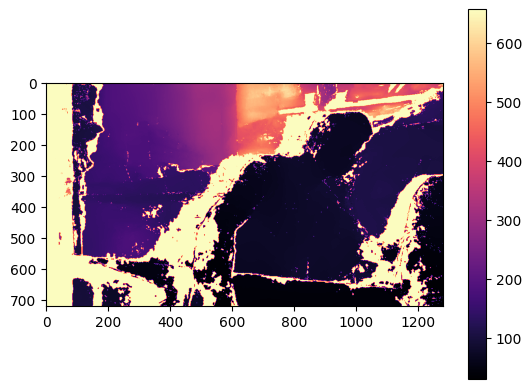

In [12]:
print(np.max(cleaned))
masked = np.ma.array(depth_nparr, mask=np.isnan(depth_nparr) | (depth_nparr > avg + 3 * std))
print(np.ma.min(masked))
plt.imshow(masked.filled(np.ma.max(masked)), cmap="magma")
plt.colorbar()
# plt.imshow(depth_nparr, alpha=np.where(np.isnan(depth_nparr), 0, 1).astype(np.float32))
# bigboi = np.max(depth_nparr[~np.isnan(depth_nparr)])
# avg = np.mean(depth_nparr[~np.isnan(depth_nparr)])
# plt.imshow(maskedarr(depth_nparr / (avg)), cmap="grey")
# print(maskedarr(depth_nparr / (avg)))
# print(dd)
# masked = np.ma.array(depth_nparr, mask=np.isnan(depth_nparr))
# masked /= np.ma.max(masked)

# plt.imshow(~masked.mask, cmap="grey")

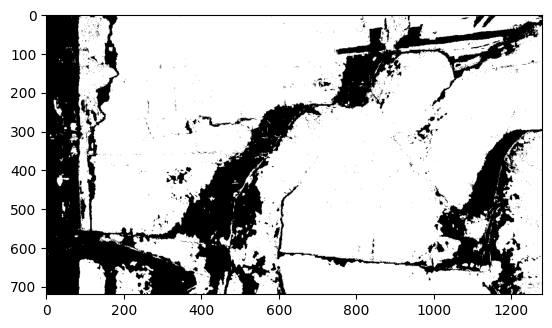

In [13]:
plt.imshow(~np.isnan(depth_cv_nparr), cmap="grey")

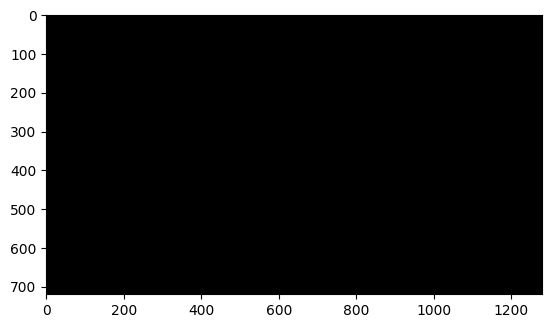

In [14]:
plt.imshow(~np.isnan(depth_nparr) != ~np.isnan(depth_cv_nparr), cmap="grey")